In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance

# Suppress warnings
warnings.filterwarnings('ignore')

# Add current directory to path
sys.path.insert(0, os.getcwd())

# Import necessary modules
from main import main
from service.data_setup import load_train_csv, split_train_validation
from service.preprocessing.cleansing import fill_missing_values
from service.preprocessing.featureExtraction import *
from service.preprocessing.encoding import one_hot_encode_and_align, drop_original_columns
from service.modeling.training import train_xgb_classifier


In [2]:
# 데이터 로드 및 전처리
print("=== 피처 중요도 분석을 위한 모델 학습 ===")

# 1. 데이터 로드
data_dir = os.path.join('data')
train_path = os.path.join(data_dir, 'hotel_bookings_train.csv')

print(f"Train 데이터 로드: {train_path}")
X, y = load_train_csv(train_path)
print(f"전체 데이터 형태: {X.shape}")

# 2. 결측치 처리
X = fill_missing_values(X)

# 3. Train/Validation 분할
X_tr, X_val, y_tr, y_val = split_train_validation(X, y, random_state=42)
print(f"Train: {X_tr.shape}, Validation: {X_val.shape}")


=== 피처 중요도 분석을 위한 모델 학습 ===
Train 데이터 로드: data\hotel_bookings_train.csv
전체 데이터 형태: (31331, 32)
Train: (25064, 32), Validation: (6267, 32)


In [3]:
# 4. 피처 엔지니어링 적용 (main.py와 동일한 순서)
print("피처 엔지니어링 수행 중...")

# featureExtraction.py에서 정의된 모든 피처들 적용
X_tr, X_val = add_total_guests_and_is_alone(X_tr, X_val)
X_tr, X_val = add_has_company(X_tr, X_val)  
X_tr, X_val = add_is_FB_meal(X_tr, X_val)
X_tr, X_val = process_adr_iqr(X_tr, X_val)
X_tr, X_val = add_total_stay(X_tr, X_val)
X_tr, X_val = process_lead_time(X_tr, X_val)
X_tr, X_val = map_hotel_type(X_tr, X_val)

# 5. 불필요한 컬럼 드롭 및 원-핫 인코딩
X_tr, X_val = drop_original_columns(X_tr, X_val)
X_tr, X_val = one_hot_encode_and_align(X_tr, X_val)

print(f"최종 피처 수: {X_tr.shape[1]}")
print("피처 엔지니어링 완료!")


피처 엔지니어링 수행 중...
최종 피처 수: 43
피처 엔지니어링 완료!


In [4]:
# 6. XGBoost 모델 학습
print("XGBoost 모델 학습 중...")
model = train_xgb_classifier(X_tr, y_tr, random_state=42)
print("모델 학습 완료!")


XGBoost 모델 학습 중...
🎯 F1-score 최적화 완료!
   최적 임계값: 0.651
   최적 F1-score: 0.728
모델 학습 완료!


=== 피처 중요도 분석 ===


<Figure size 1200x800 with 0 Axes>

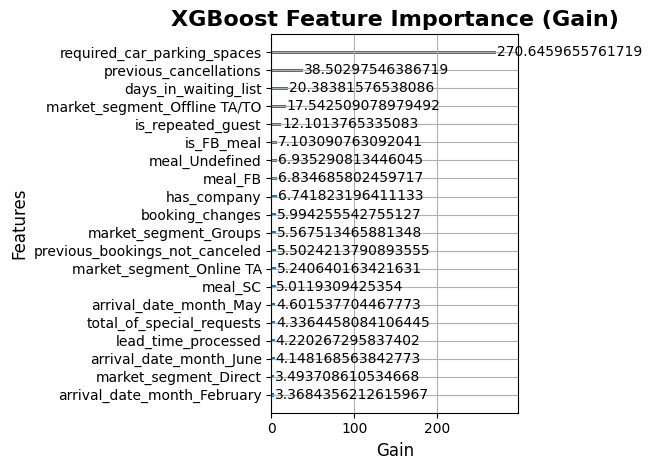

In [5]:
# 7. 피처 중요도 시각화
print("=== 피처 중요도 분석 ===")

# 피처 중요도 그래프 생성 (gain 기준)
plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='gain', max_num_features=20)
plt.title('XGBoost Feature Importance (Gain)', fontsize=16, fontweight='bold')
plt.xlabel('Gain', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()


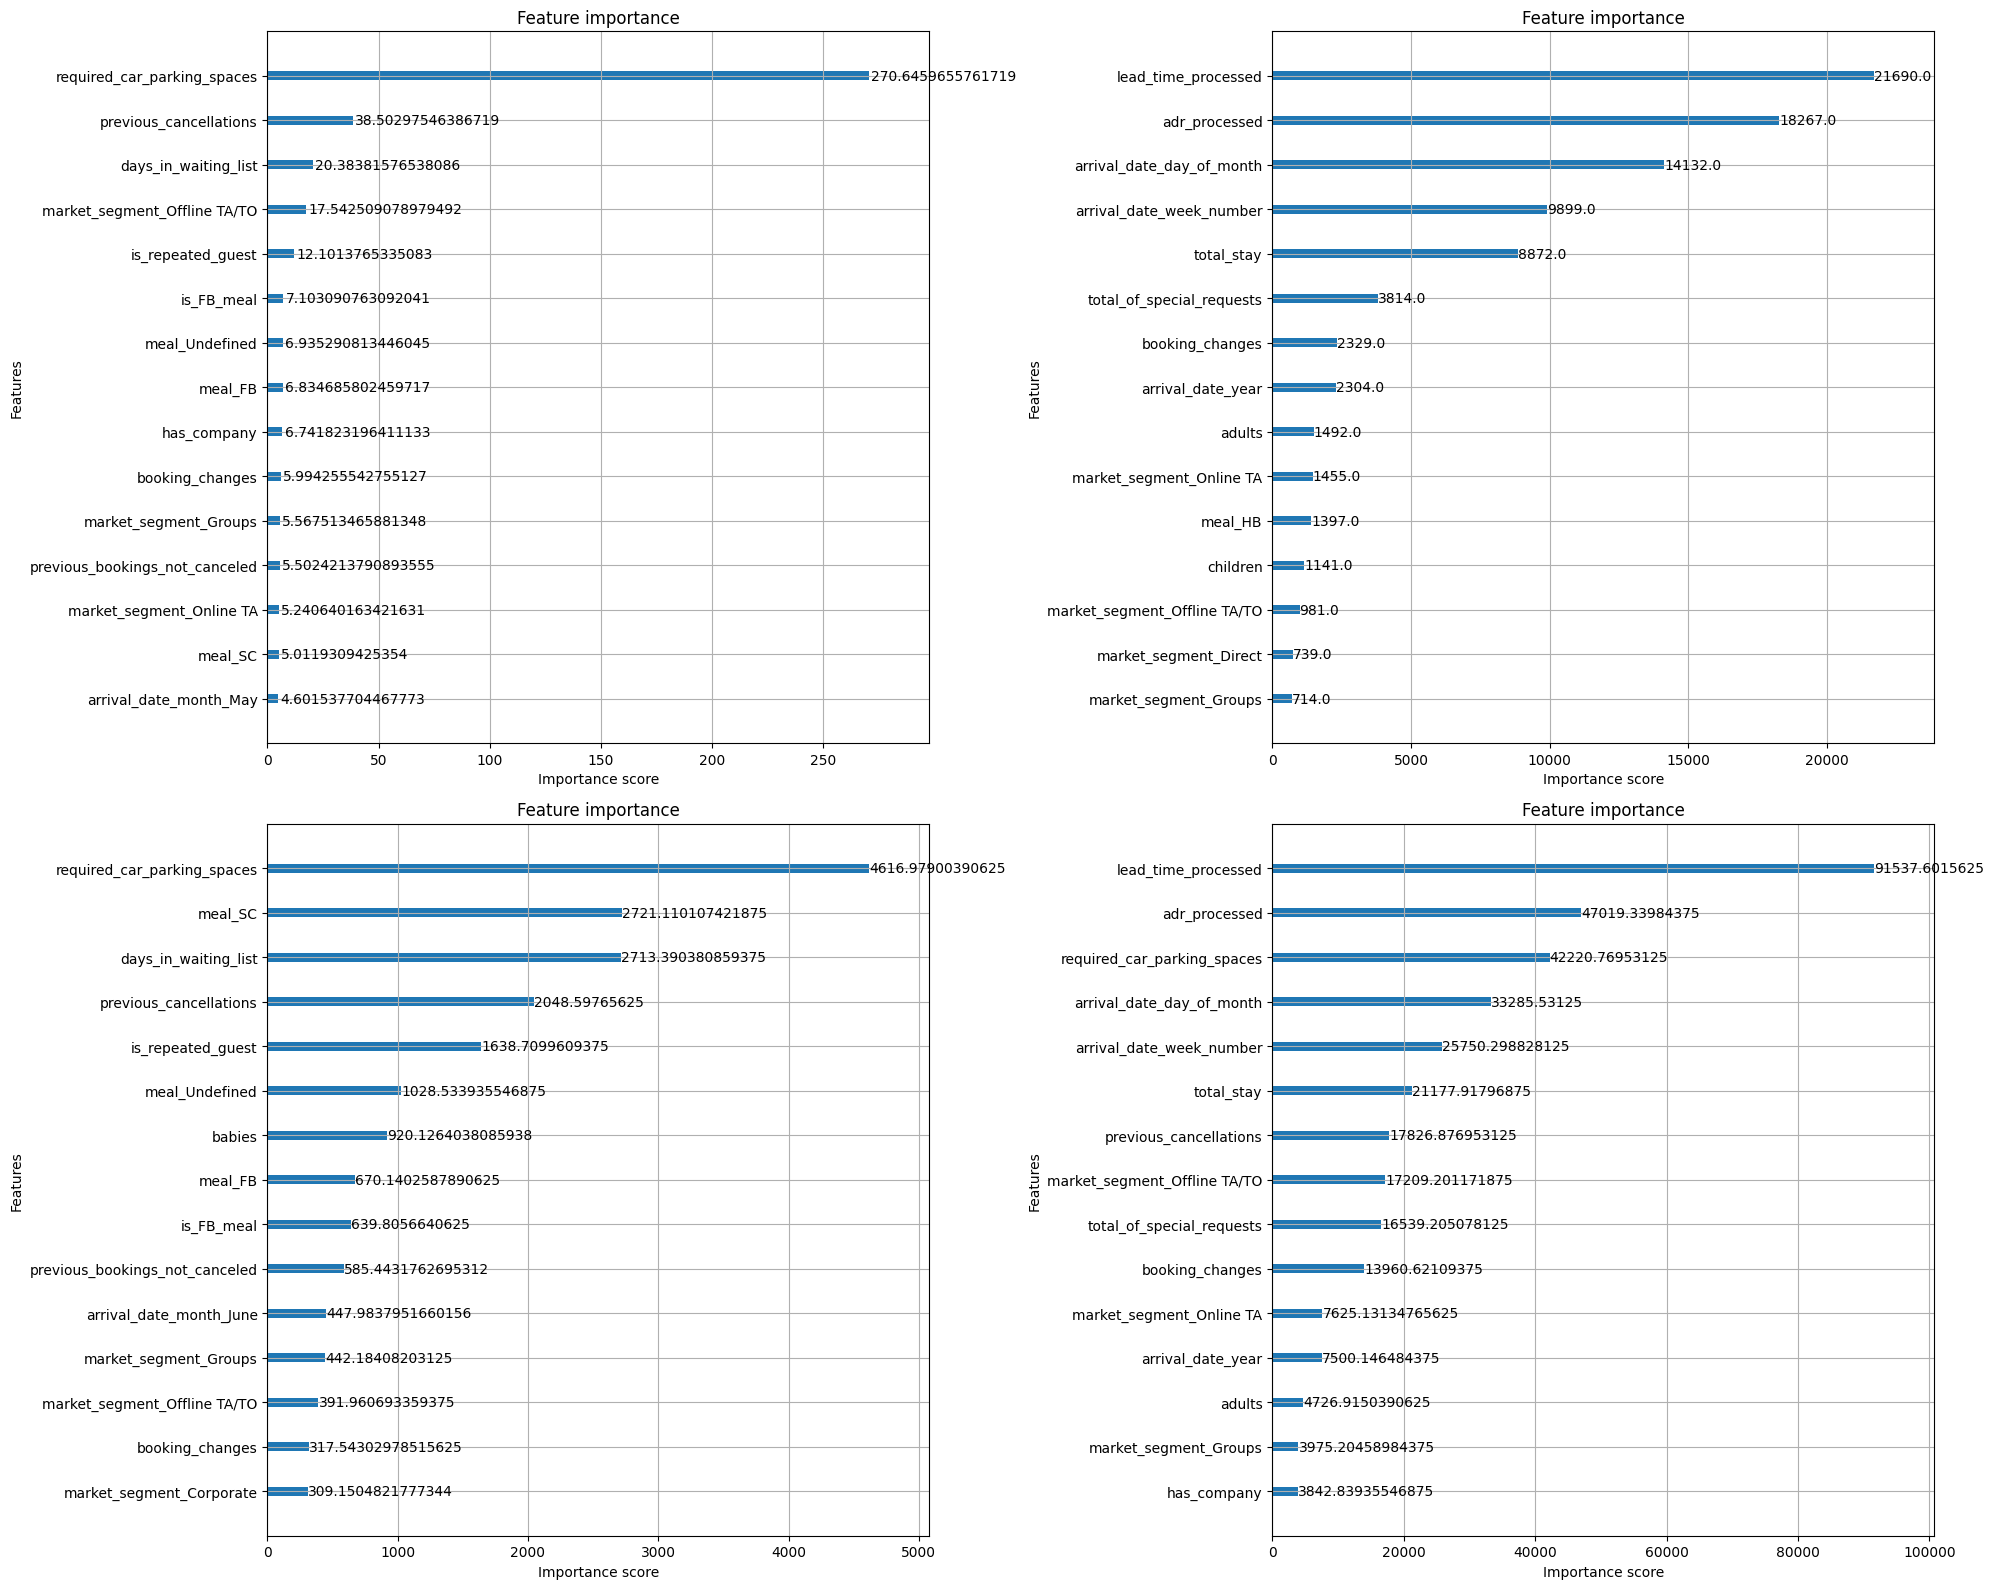

In [6]:
# 8. 추가 피처 중요도 분석 (다양한 importance_type으로)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Gain 기준
axes[0, 0].set_title('Feature Importance - Gain', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='gain', max_num_features=15, ax=axes[0, 0])

# Weight 기준 (사용 빈도)
axes[0, 1].set_title('Feature Importance - Weight', fontsize=14, fontweight='bold')  
plot_importance(model, importance_type='weight', max_num_features=15, ax=axes[0, 1])

# Cover 기준
axes[1, 0].set_title('Feature Importance - Cover', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='cover', max_num_features=15, ax=axes[1, 0])

# Total Gain 기준
axes[1, 1].set_title('Feature Importance - Total Gain', fontsize=14, fontweight='bold')
plot_importance(model, importance_type='total_gain', max_num_features=15, ax=axes[1, 1])

plt.tight_layout()
plt.show()


In [7]:
# 9. 피처 중요도 상위 피처들 분석
import pandas as pd

# 피처 중요도를 DataFrame으로 정리
feature_importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(feature_importance.items()), 
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)

print("=== 상위 20개 중요 피처 (Gain 기준) ===")
print(importance_df.head(20))

# featureExtraction.py에서 만든 피처들 식별
engineered_features = ['is_alone', 'has_company', 'is_FB_meal', 'adr_processed', 
                      'total_stay', 'lead_time_processed', 'is_resort']

print("\n=== 피처 엔지니어링으로 생성된 피처들의 중요도 ===")
engineered_importance = importance_df[importance_df['feature'].isin(engineered_features)]
if not engineered_importance.empty:
    print(engineered_importance)
else:
    print("피처 엔지니어링 피처들이 상위 피처에 포함되지 않았습니다.")


=== 상위 20개 중요 피처 (Gain 기준) ===
                         feature  importance
11   required_car_parking_spaces  270.645966
7         previous_cancellations   38.502975
10          days_in_waiting_list   20.383816
37  market_segment_Offline TA/TO   17.542509
6              is_repeated_guest   12.101377
..                           ...         ...
12     total_of_special_requests    4.336446
18           lead_time_processed    4.220267
24       arrival_date_month_June    4.148169
35         market_segment_Direct    3.493709
21   arrival_date_month_February    3.368436

[20 rows x 2 columns]

=== 피처 엔지니어링으로 생성된 피처들의 중요도 ===
                feature  importance
15           is_FB_meal    7.103091
14          has_company    6.741823
18  lead_time_processed    4.220267
13             is_alone    3.199484
16        adr_processed    2.574004
17           total_stay    2.387051
